In [25]:
# using GuSTO
include("../src/GuSTO.jl")

Forest

In [26]:
robot = Car()
model = DubinsCar()
env = BlankEnv()

N = 41
x_init = 2*ones(3)
x_goal = zeros(3)
tf_guess = 5.

PD = ProblemDefinition(robot, model, env, x_init, x_goal)
TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
TOS_SCP = TrajectoryOptimizationSolution(TOP)

TrajectoryOptimizationSolution(Trajectory([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0], 5.0, 0.125), #undef, #undef, #undef)

In [27]:
# SCP Only
TOS_SCP = TrajectoryOptimizationSolution(TOP)
# solve_SCP!(TOS_SCP, TOP, solve_gusto_cvx!, init_traj_straightline, "Gurobi", OutputFlag=0)
solve_SCP!(TOS_SCP, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)

@show TOS_SCP.SCPS.converged
@show TOS_SCP.SCPS.iterations
@show TOS_SCP.SCPS.total_time
@show TOS_SCP.SCPS.J_true[end]
@show TOS_SCP.SCPS.traj.U

(TOS_SCP.SCPS).converged = true
(TOS_SCP.SCPS).iterations = 12
(TOS_SCP.SCPS).total_time = 0.709542073
(TOS_SCP.SCPS).J_true[end] = 14.756626877595485
((TOS_SCP.SCPS).traj).U = [1.17075 2.39145 2.45905 2.45606 2.37882 2.23611 2.04291 1.81666 1.57374 1.32712 1.08561 0.854046 0.63408 0.42506 0.224808 0.0302263 -0.162263 -0.356386 -0.555725 -0.763416 -0.981742 -1.21159 -1.45174 -1.69803 -1.94249 -2.17297 -2.37352 -2.52621 -2.61448 -2.62718 -2.56195 -2.42623 -2.2354 -2.00876 -1.76526 -1.5205 -1.28534 -1.06602 -0.865049 -0.899232]


1×40 Array{Float64,2}:
 1.17075  2.39145  2.45905  2.45606  …  -1.06602  -0.865049  -0.899232

In [28]:
TOS_SCP.SCPS.J_true

13-element Array{Any,1}:
  0.0              
 50.74210571645625 
 42.01206501991294 
 32.457028857488595
  9.170540524825682
 16.45880691752511 
 17.408643497790255
 17.138465668743706
 16.29446987126495 
 15.15286503531522 
 14.606655695142983
 14.710863180692739
 14.756626877595485

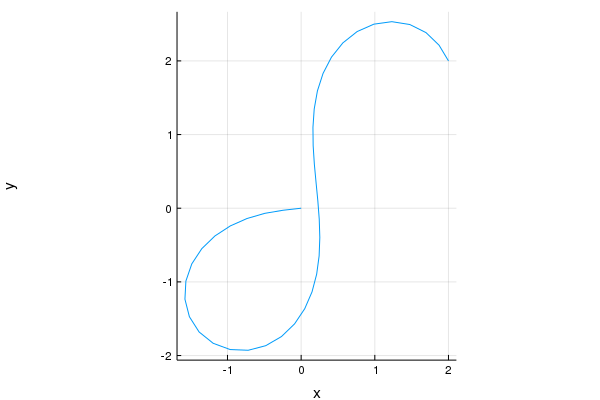

In [29]:
using Plots
gr(fmt=:png)
plot([TOS_SCP.SCPS.traj.X[1,:]], [TOS_SCP.SCPS.traj.X[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

In [30]:
TOS_SCPS  = TrajectoryOptimizationSolution(TOP)
solve_SCPshooting!(TOS_SCPS, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)

@show TOS_SCPS.SS.converged
@show TOS_SCPS.SS.traj.X[1,:]
@show TOS_SCPS.SCPS.iterations
@show TOS_SCPS.SS.traj.U
# @show TOS_SCPS.SS.total_time
# @show TOS_SCPS.SS.J_true[end]

MethodError: MethodError: no method matching ShootingProblem(::TrajectoryOptimizationProblem{Car,DubinsCar,BlankEnv}, ::SCPSolution, ::SCPProblem{Car,DubinsCar,BlankEnv})
Closest candidates are:
  ShootingProblem(!Matched::ProblemDefinition{R<:Robot,D<:DynamicsModel,E<:Environment}, ::Any, ::Any, !Matched::Any) where {R<:Robot, D<:DynamicsModel, E<:Environment} at /home/bylard/.julia/dev/GuSTO/src/types.jl:154
  ShootingProblem(::TrajectoryOptimizationProblem, ::SCPSolution) at /home/bylard/.julia/dev/GuSTO/src/types.jl:184

In [31]:
using Plots
gr(fmt=:png)
plot([TOS_SCPS.SS.traj.X[1,:]], [TOS_SCPS.SS.traj.X[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

UndefRefError: UndefRefError: access to undefined reference